In [ ]:
#%pip install pandas numpy scikit-learn xgboost catboost matplotlib seaborn

In [32]:
"""
Telco Customer Churn – Full Exercise Script
===========================================

Steps:
1. Load & explore data
2. Preprocess (missing values, encoding, scaling)
3. Train baseline models:
   - Logistic Regression
   - Decision Tree
   - Random Forest
   - XGBoost
   - CatBoost
   - k-NN
4. Evaluate (Accuracy, Precision, Recall, F1, Confusion Matrix, ROC/AUC)
5. Overfitting analysis (train vs test)
6. Hyperparameter tuning with GridSearchCV / RandomizedSearchCV
7. Feature importance & interpretation
8. (Optional) Stacking classifier
"""

import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer

from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, StackingClassifier
from sklearn.neighbors import KNeighborsClassifier

from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    roc_auc_score,
    roc_curve,
    classification_report
)

from xgboost import XGBClassifier
from catboost import CatBoostClassifier

RANDOM_STATE = 42


In [33]:
import sweetviz as sv

In [34]:
# Change this path to where you saved the Kaggle CSV
#from pathlib import Path
#import pandas as pd
csv_path = Path("WA_Fn-UseC_-Telco-Customer-Churn.csv")
df = pd.read_csv(csv_path)

# אם גדול מדי, אפשר דוגמית
# df = df.sample(5000, random_state=42)
if not hasattr(np, "VisibleDeprecationWarning"):
    class VisibleDeprecationWarning(UserWarning):
        pass
    np.VisibleDeprecationWarning = VisibleDeprecationWarning
report = sv.analyze(df)
report.show_html("sweetviz_eda.html")


Done! Use 'show' commands to display/save.   |██████████| [100%]   00:00 -> (00:00 left)

Report sweetviz_eda.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [35]:

# ============================================================
# Step 1 – Load & Explore Data
# ============================================================

def load_data():
    # Change this path to where you saved the Kaggle CSV
    csv_path = Path("WA_Fn-UseC_-Telco-Customer-Churn.csv")
    df = pd.read_csv(csv_path)

    print("\n=== Head ===")
    print(df.head())

    print("\n=== Info ===")
    print(df.info())

    print("\n=== Missing values per column ===")
    print(df.isna().sum())

    print("\n=== Churn distribution ===")
    print(df['Churn'].value_counts(normalize=True))

    # Optional: simple churn bar plot
    plt.figure()
    df['Churn'].value_counts().plot(kind='bar')
    plt.title("Churn class counts")
    plt.xticks(rotation=0)
    plt.show()
    return df


In [36]:
# ============================================================
# Step 2 – Data Preparation
# ============================================================

def prepare_data(df):
    # TotalCharges sometimes has spaces; coerce to numeric
    df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors='coerce')

    # Drop customerID (identifier)
    df = df.drop(columns=['customerID'])

    # Handle target encoding: Yes -> 1, No -> 0
    df['Churn'] = df['Churn'].map({'Yes': 1, 'No': 0})

    # Basic missing values check
    print("\nMissing values after TotalCharges conversion:")
    print(df.isna().sum())

    # Separate features and target
    X = df.drop(columns=['Churn'])
    y = df['Churn']

    # Identify categorical and numerical features
    numeric_features = X.select_dtypes(include=['int64', 'float64']).columns.tolist()
    categorical_features = X.select_dtypes(include=['object']).columns.tolist()

    print("\nNumeric features:", numeric_features)
    print("Categorical features:", categorical_features)

    # Preprocessing for numeric features: impute + scale
    numeric_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler())
        ]
    )

    # Preprocessing for categorical features: impute + one-hot
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]
    )

    preprocessor = ColumnTransformer(
        transformers=[
            ("num", numeric_transformer, numeric_features),
            ("cat", categorical_transformer, categorical_features),
        ]
    )

    # Train / test split (80/20), stratify for class imbalance
    X_train, X_test, y_train, y_test = train_test_split(
        X,
        y,
        test_size=0.2,
        random_state=RANDOM_STATE,
        stratify=y
    )

    print(f"\nTrain size: {X_train.shape}, Test size: {X_test.shape}")

    return X_train, X_test, y_train, y_test, preprocessor


In [37]:
# ============================================================
# Utility – Evaluation & Plotting
# ============================================================

def evaluate_model(name, model, X_train, X_test, y_train, y_test, results_list, plot_roc=True):
    """
    Fit a model, evaluate on train & test, store metrics in results_list.
    Also optionally plot ROC curve and confusion matrix.
    """
    print(f"\n{'='*60}\nTraining {name}\n{'='*60}")

    model.fit(X_train, y_train)

    # Predictions
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)

    if hasattr(model, "predict_proba"):
        y_test_proba = model.predict_proba(X_test)[:, 1]
        y_train_proba = model.predict_proba(X_train)[:, 1]
    else:
        # Fallback to decision_function if no predict_proba
        if hasattr(model, "decision_function"):
            y_test_proba = model.decision_function(X_test)
            y_train_proba = model.decision_function(X_train)
        else:
            # If truly no probabilities, approximate with predictions
            y_test_proba = y_test_pred
            y_train_proba = y_train_pred

    # Metrics – test
    acc_test = accuracy_score(y_test, y_test_pred)
    prec_test = precision_score(y_test, y_test_pred)
    rec_test = recall_score(y_test, y_test_pred)
    f1_test = f1_score(y_test, y_test_pred)
    auc_test = roc_auc_score(y_test, y_test_proba)

    # Metrics – train (for overfitting analysis)
    acc_train = accuracy_score(y_train, y_train_pred)
    prec_train = precision_score(y_train, y_train_pred)
    rec_train = recall_score(y_train, y_train_pred)
    f1_train = f1_score(y_train, y_train_pred)
    auc_train = roc_auc_score(y_train, y_train_proba)

    print("\nClassification report (test):")
    print(classification_report(y_test, y_test_pred))

    print("Train vs Test comparison:")
    print(f"Accuracy  - train: {acc_train:.3f}, test: {acc_test:.3f}")
    print(f"Precision - train: {prec_train:.3f}, test: {prec_test:.3f}")
    print(f"Recall    - train: {rec_train:.3f}, test: {rec_test:.3f}")
    print(f"F1-score  - train: {f1_train:.3f}, test: {f1_test:.3f}")
    print(f"ROC AUC   - train: {auc_train:.3f}, test: {auc_test:.3f}")

    # Confusion matrix
    cm = confusion_matrix(y_test, y_test_pred)
    plt.figure()
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues")
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    if plot_roc:
        fpr, tpr, _ = roc_curve(y_test, y_test_proba)
        plt.figure()
        plt.plot(fpr, tpr, label=f"{name} (AUC = {auc_test:.3f})")
        plt.plot([0, 1], [0, 1], linestyle="--")
        plt.xlabel("False Positive Rate")
        plt.ylabel("True Positive Rate")
        plt.title(f"ROC Curve – {name}")
        plt.legend()
        plt.show()

    results_list.append({
        "model": name,
        "acc_train": acc_train,
        "prec_train": prec_train,
        "rec_train": rec_train,
        "f1_train": f1_train,
        "auc_train": auc_train,
        "acc_test": acc_test,
        "prec_test": prec_test,
        "rec_test": rec_test,
        "f1_test": f1_test,
        "auc_test": auc_test
    })


def print_results_table(results_list, title="Model Comparison"):
    df_results = pd.DataFrame(results_list)
    print(f"\n=== {title} ===")
    print(df_results.sort_values(by="auc_test", ascending=False).round(3))



In [38]:
# ============================================================
# Step 3 – Baseline Models
# ============================================================

def get_baseline_models(preprocessor):
    models = {}

    models["Logistic Regression"] = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
        ]
    )

    models["Decision Tree"] = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
        ]
    )

    models["Random Forest"] = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", RandomForestClassifier(
                n_estimators=200, random_state=RANDOM_STATE
            ))
        ]
    )

    models["XGBoost"] = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                n_estimators=200,
                learning_rate=0.1,
                max_depth=4,
                subsample=0.8,
                colsample_bytree=0.8,
                random_state=RANDOM_STATE,
                use_label_encoder=False
            ))
        ]
    )

    models["CatBoost"] = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", CatBoostClassifier(
                iterations=200,
                learning_rate=0.1,
                depth=4,
                loss_function="Logloss",
                verbose=False,
                random_state=RANDOM_STATE
            ))
        ]
    )

    models["k-NN"] = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", KNeighborsClassifier(n_neighbors=5, weights="distance"))
        ]
    )

    return models



In [41]:
# ============================================================
# Step 6 – Hyperparameter Tuning
# ============================================================

def tune_models(preprocessor, X_train, y_train):
    tuned_models = {}
    tuned_results = []

    # ---------------- Logistic Regression ----------------
    log_reg = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE))
        ]
    )

    param_grid_lr = {
        "clf__C": [0.01, 0.1, 1, 10],
        "clf__penalty": ["l2"],
        "clf__solver": ["lbfgs", "liblinear"]
    }

    grid_lr = GridSearchCV(
        estimator=log_reg,
        param_grid=param_grid_lr,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1
    )
    grid_lr.fit(X_train, y_train)
    print("\nBest Logistic Regression:", grid_lr.best_params_, "AUC:", grid_lr.best_score_)
    tuned_models["Logistic Regression (tuned)"] = grid_lr.best_estimator_

    # ---------------- Decision Tree ----------------
    dt = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", DecisionTreeClassifier(random_state=RANDOM_STATE))
        ]
    )

 #   param_grid_dt = {
 #       "clf__max_depth": [3, 5, 8, None],
 #       "clf__min_samples_split": [2, 5, 10],
 #       "clf__min_samples_leaf": [1, 5, 10]
 #   }
    param_grid_dt = {
        #"criterion": ["gini", "log_loss"],
        "clf__max_depth": [3, 5, 7, 9, None],
        "clf__min_samples_split": [2, 10, 20, 50],
        "clf__min_samples_leaf": [1, 5, 10, 20]
    }



    grid_dt = GridSearchCV(
        estimator=dt,
        param_grid=param_grid_dt,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1
    )
    grid_dt.fit(X_train, y_train)
    print("\nBest Decision Tree:", grid_dt.best_params_, "AUC:", grid_dt.best_score_)
    tuned_models["Decision Tree (tuned)"] = grid_dt.best_estimator_

    # ---------------- Random Forest ----------------
    rf = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", RandomForestClassifier(random_state=RANDOM_STATE))
        ]
    )

    param_grid_rf = {
        "clf__n_estimators": [100, 200, 400],
        "clf__max_depth": [None, 5, 8, 12],
        "clf__max_features": ["sqrt", "log2"],
        "clf__min_samples_split": [2, 5, 10]
    }

    rand_rf = RandomizedSearchCV(
        estimator=rf,
        param_distributions=param_grid_rf,
        n_iter=15,
        cv=5,
        scoring="roc_auc",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rand_rf.fit(X_train, y_train)
    print("\nBest Random Forest:", rand_rf.best_params_, "AUC:", rand_rf.best_score_)
    tuned_models["Random Forest (tuned)"] = rand_rf.best_estimator_

    # ---------------- XGBoost ----------------
    xgb = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", XGBClassifier(
                objective="binary:logistic",
                eval_metric="logloss",
                use_label_encoder=False,
                random_state=RANDOM_STATE
            ))
        ]
    )

    param_grid_xgb = {
        "clf__n_estimators": [100, 200, 400],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__max_depth": [3, 4, 5, 6],
        "clf__subsample": [0.8, 1.0],
        "clf__colsample_bytree": [0.8, 1.0]
    }

    rand_xgb = RandomizedSearchCV(
        estimator=xgb,
        param_distributions=param_grid_xgb,
        n_iter=15,
        cv=5,
        scoring="roc_auc",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rand_xgb.fit(X_train, y_train)
    print("\nBest XGBoost:", rand_xgb.best_params_, "AUC:", rand_xgb.best_score_)
    tuned_models["XGBoost (tuned)"] = rand_xgb.best_estimator_

    # ---------------- CatBoost ----------------
    cat = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", CatBoostClassifier(
                loss_function="Logloss",
                verbose=False,
                random_state=RANDOM_STATE
            ))
        ]
    )

    param_grid_cat = {
        "clf__iterations": [200, 400],
        "clf__learning_rate": [0.01, 0.05, 0.1],
        "clf__depth": [3, 4, 5, 6]
    }

    rand_cat = RandomizedSearchCV(
        estimator=cat,
        param_distributions=param_grid_cat,
        n_iter=10,
        cv=5,
        scoring="roc_auc",
        random_state=RANDOM_STATE,
        n_jobs=-1
    )
    rand_cat.fit(X_train, y_train)
    print("\nBest CatBoost:", rand_cat.best_params_, "AUC:", rand_cat.best_score_)
    tuned_models["CatBoost (tuned)"] = rand_cat.best_estimator_

    # ---------------- k-NN ----------------
    knn = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", KNeighborsClassifier())
        ]
    )

    param_grid_knn = {
        "clf__n_neighbors": [3, 5, 7, 11],
        "clf__weights": ["uniform", "distance"],
        "clf__p": [1, 2]  # Manhattan / Euclidean
    }

    grid_knn = GridSearchCV(
        estimator=knn,
        param_grid=param_grid_knn,
        cv=5,
        scoring="roc_auc",
        n_jobs=-1
    )
    grid_knn.fit(X_train, y_train)
    print("\nBest k-NN:", grid_knn.best_params_, "AUC:", grid_knn.best_score_)
    tuned_models["k-NN (tuned)"] = grid_knn.best_estimator_

    return tuned_models




=== Head ===
   customerID  gender  SeniorCitizen Partner Dependents  tenure PhoneService  \
0  7590-VHVEG  Female              0     Yes         No       1           No   
1  5575-GNVDE    Male              0      No         No      34          Yes   
2  3668-QPYBK    Male              0      No         No       2          Yes   
3  7795-CFOCW    Male              0      No         No      45           No   
4  9237-HQITU  Female              0      No         No       2          Yes   

      MultipleLines InternetService OnlineSecurity  ... DeviceProtection  \
0  No phone service             DSL             No  ...               No   
1                No             DSL            Yes  ...              Yes   
2                No             DSL            Yes  ...               No   
3  No phone service             DSL            Yes  ...              Yes   
4                No     Fiber optic             No  ...               No   

  TechSupport StreamingTV StreamingMovies       

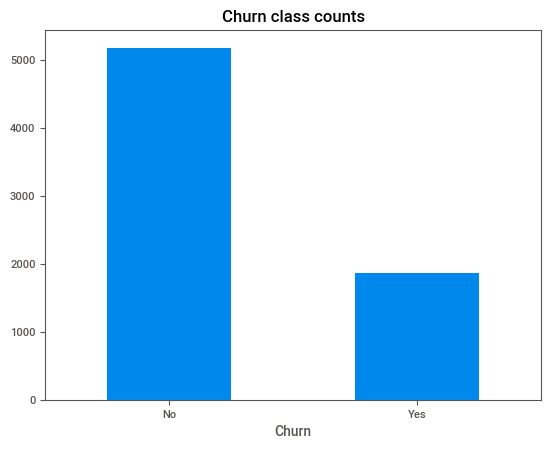


Missing values after TotalCharges conversion:
gender               0
SeniorCitizen        0
Partner              0
Dependents           0
tenure               0
PhoneService         0
MultipleLines        0
InternetService      0
OnlineSecurity       0
OnlineBackup         0
DeviceProtection     0
TechSupport          0
StreamingTV          0
StreamingMovies      0
Contract             0
PaperlessBilling     0
PaymentMethod        0
MonthlyCharges       0
TotalCharges        11
Churn                0
dtype: int64

Numeric features: ['SeniorCitizen', 'tenure', 'MonthlyCharges', 'TotalCharges']
Categorical features: ['gender', 'Partner', 'Dependents', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod']

Train size: (5634, 19), Test size: (1409, 19)

Training Logistic Regression

Classification report (test):
              precision    re

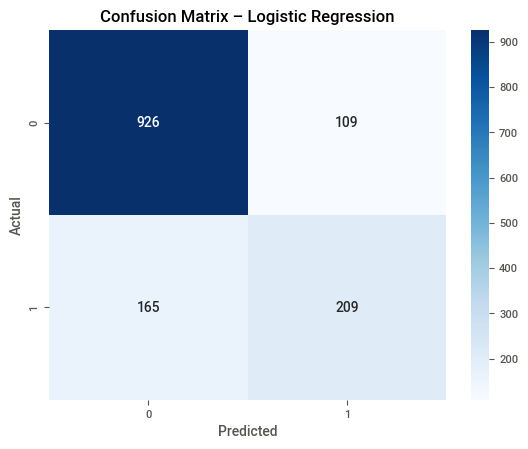

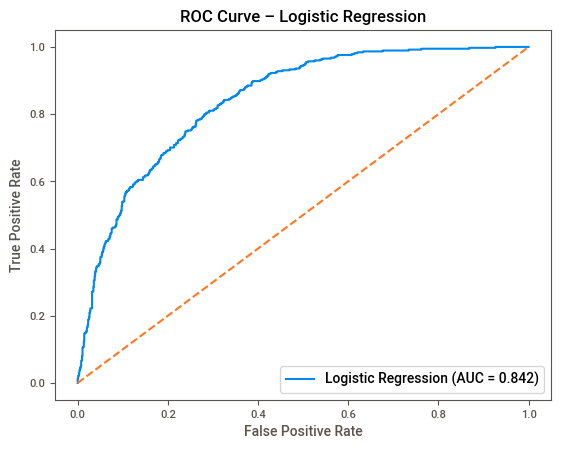


Training Decision Tree

Classification report (test):
              precision    recall  f1-score   support

           0       0.82      0.81      0.81      1035
           1       0.49      0.51      0.50       374

    accuracy                           0.73      1409
   macro avg       0.65      0.66      0.66      1409
weighted avg       0.73      0.73      0.73      1409

Train vs Test comparison:
Accuracy  - train: 0.998, test: 0.729
Precision - train: 0.999, test: 0.490
Recall    - train: 0.993, test: 0.505
F1-score  - train: 0.996, test: 0.497
ROC AUC   - train: 1.000, test: 0.657


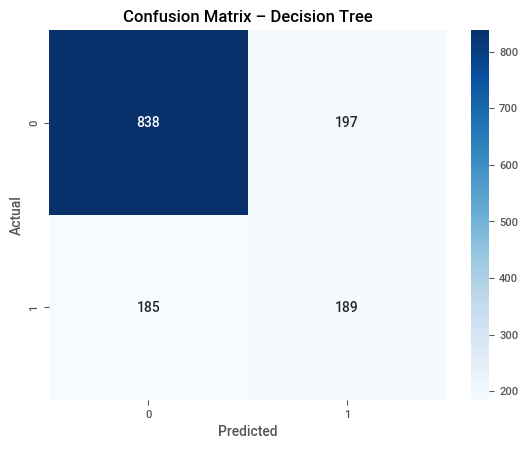

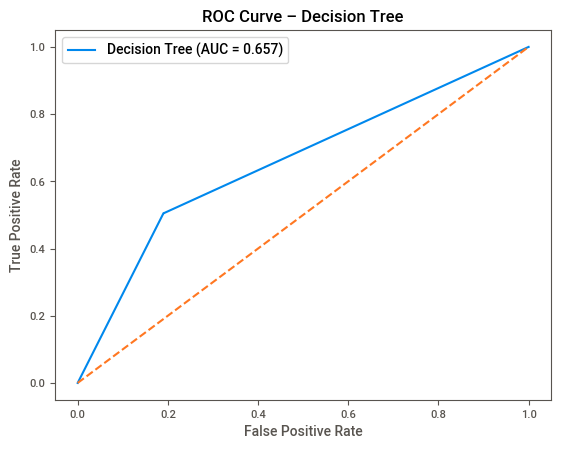


Training Random Forest

Classification report (test):
              precision    recall  f1-score   support

           0       0.82      0.89      0.85      1035
           1       0.60      0.47      0.52       374

    accuracy                           0.78      1409
   macro avg       0.71      0.68      0.69      1409
weighted avg       0.76      0.78      0.77      1409

Train vs Test comparison:
Accuracy  - train: 0.998, test: 0.776
Precision - train: 0.997, test: 0.600
Recall    - train: 0.995, test: 0.465
F1-score  - train: 0.996, test: 0.524
ROC AUC   - train: 1.000, test: 0.819


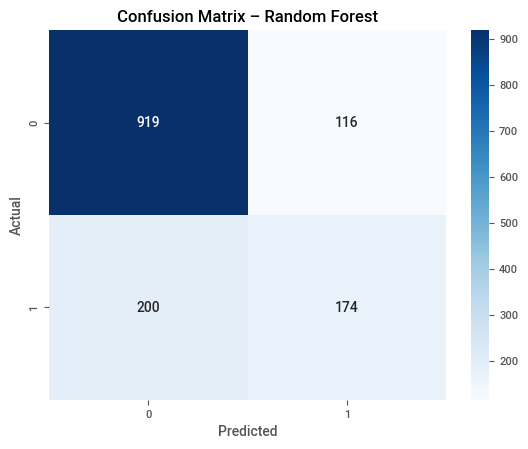

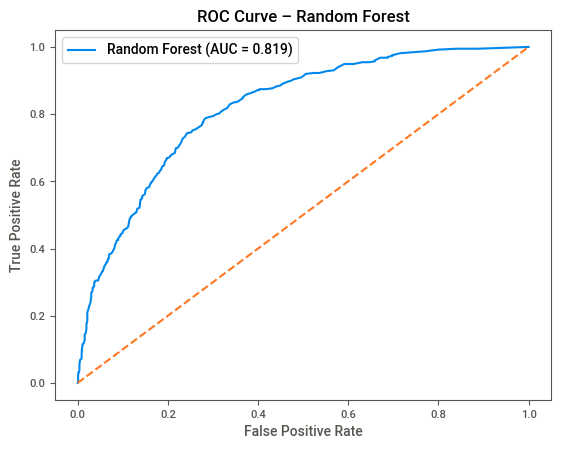


Training XGBoost

Classification report (test):
              precision    recall  f1-score   support

           0       0.84      0.89      0.87      1035
           1       0.64      0.54      0.58       374

    accuracy                           0.80      1409
   macro avg       0.74      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Train vs Test comparison:
Accuracy  - train: 0.854, test: 0.797
Precision - train: 0.768, test: 0.640
Recall    - train: 0.643, test: 0.537
F1-score  - train: 0.700, test: 0.584
ROC AUC   - train: 0.922, test: 0.838


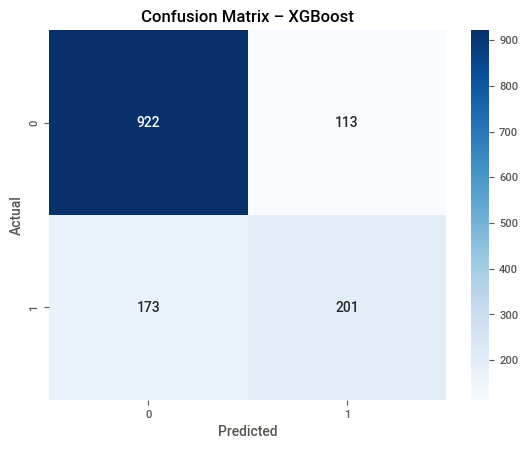

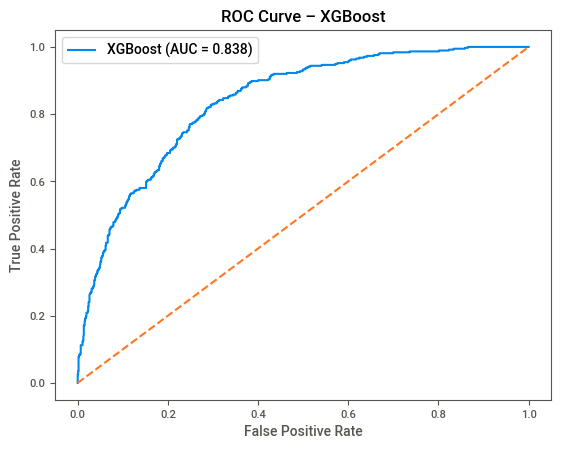


Training CatBoost

Classification report (test):
              precision    recall  f1-score   support

           0       0.84      0.91      0.87      1035
           1       0.67      0.52      0.58       374

    accuracy                           0.80      1409
   macro avg       0.75      0.71      0.73      1409
weighted avg       0.79      0.80      0.79      1409

Train vs Test comparison:
Accuracy  - train: 0.837, test: 0.803
Precision - train: 0.745, test: 0.666
Recall    - train: 0.586, test: 0.516
F1-score  - train: 0.656, test: 0.581
ROC AUC   - train: 0.894, test: 0.843


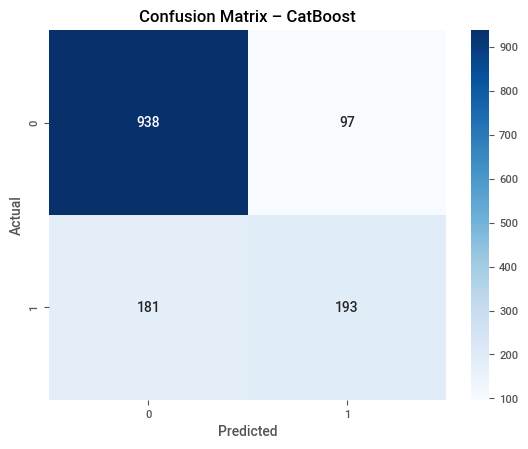

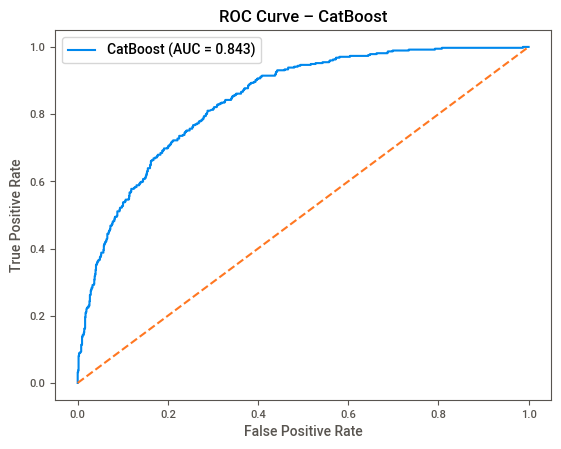


Training k-NN

Classification report (test):
              precision    recall  f1-score   support

           0       0.84      0.83      0.84      1035
           1       0.55      0.55      0.55       374

    accuracy                           0.76      1409
   macro avg       0.69      0.69      0.69      1409
weighted avg       0.76      0.76      0.76      1409

Train vs Test comparison:
Accuracy  - train: 0.998, test: 0.760
Precision - train: 0.999, test: 0.548
Recall    - train: 0.993, test: 0.553
F1-score  - train: 0.996, test: 0.551
ROC AUC   - train: 1.000, test: 0.774


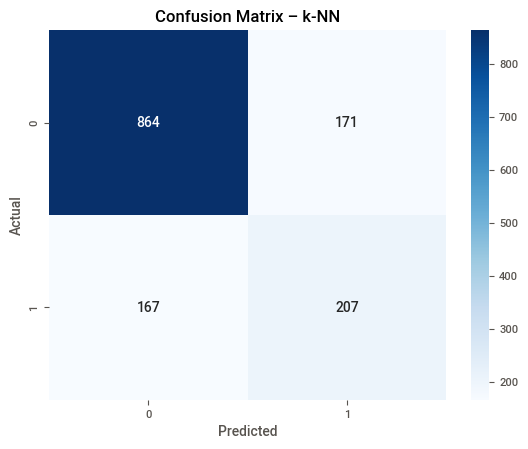

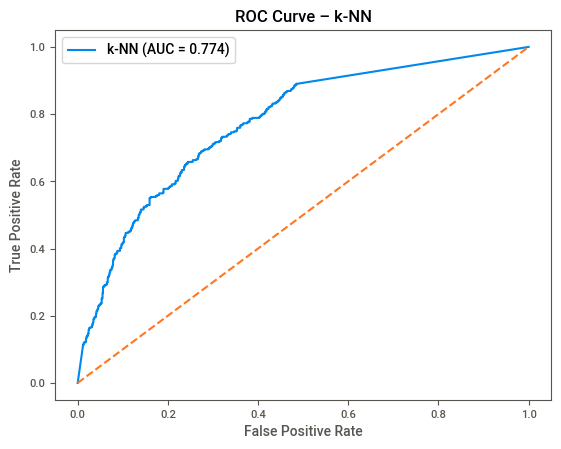


=== Baseline Models ===
                 model  acc_train  prec_train  rec_train  f1_train  auc_train  \
4             CatBoost      0.837       0.745      0.586     0.656      0.894   
0  Logistic Regression      0.806       0.662      0.551     0.601      0.849   
3              XGBoost      0.854       0.768      0.643     0.700      0.922   
2        Random Forest      0.998       0.997      0.995     0.996      1.000   
5                 k-NN      0.998       0.999      0.993     0.996      1.000   
1        Decision Tree      0.998       0.999      0.993     0.996      1.000   

   acc_test  prec_test  rec_test  f1_test  auc_test  
4     0.803      0.666     0.516    0.581     0.843  
0     0.806      0.657     0.559    0.604     0.842  
3     0.797      0.640     0.537    0.584     0.838  
2     0.776      0.600     0.465    0.524     0.819  
5     0.760      0.548     0.553    0.551     0.774  
1     0.729      0.490     0.505    0.497     0.657  

Best Logistic Regression: {'

In [ ]:
# ============================================================
# Step 7 – Feature Importance / Interpretation
# ============================================================

def get_feature_names(preprocessor, X):
    # Get feature names after ColumnTransformer (numeric + one-hot)
    numeric_features = preprocessor.transformers_[0][2]
    cat_features = preprocessor.transformers_[1][2]
    cat_ohe = preprocessor.named_transformers_["cat"]["onehot"]
    cat_feature_names = cat_ohe.get_feature_names_out(cat_features)
    feature_names = np.concatenate([numeric_features, cat_feature_names])
    return feature_names


def show_feature_importance_for_model(name, fitted_pipeline, X_train, top_n=15):
    print(f"\n=== Feature importance for {name} ===")

    preprocess = fitted_pipeline.named_steps["preprocess"]
    clf = fitted_pipeline.named_steps["clf"]

    feature_names = get_feature_names(preprocess, X_train)

    importances = None

    # Logistic Regression coefficients
    if isinstance(clf, LogisticRegression):
        importances = clf.coef_[0]

    # Tree-based models
    if hasattr(clf, "feature_importances_"):
        importances = clf.feature_importances_

    if importances is None:
        print("No feature importance available for this model.")
        return

    importance_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", key=lambda s: np.abs(s), ascending=False)

    print(importance_df.head(top_n))

    plt.figure(figsize=(8, 6))
    sns.barplot(
        data=importance_df.head(top_n),
        x="importance",
        y="feature"
    )
    plt.title(f"Top {top_n} features – {name}")
    plt.tight_layout()
    plt.show()


# ============================================================
# Step 8 – Optional Stacking Classifier
# ============================================================

def build_stacking_model(preprocessor):
    base_estimators = [
        ("log_reg", LogisticRegression(max_iter=1000, random_state=RANDOM_STATE)),
        ("rf", RandomForestClassifier(n_estimators=200, random_state=RANDOM_STATE)),
        ("xgb", XGBClassifier(
            objective="binary:logistic",
            eval_metric="logloss",
            n_estimators=200,
            learning_rate=0.1,
            max_depth=4,
            subsample=0.8,
            colsample_bytree=0.8,
            random_state=RANDOM_STATE,
            use_label_encoder=False
        ))
    ]

    stacking_clf = StackingClassifier(
        estimators=base_estimators,
        final_estimator=LogisticRegression(max_iter=1000, random_state=RANDOM_STATE),
        passthrough=False
    )

    model = Pipeline(
        steps=[
            ("preprocess", preprocessor),
            ("clf", stacking_clf)
        ]
    )

    return model


# ============================================================
# MAIN
# ============================================================

def main():
    # 1. Load and explore
    df = load_data()

    # 2. Prepare data
    X_train, X_test, y_train, y_test, preprocessor = prepare_data(df)

    # 3. Baseline models
    baseline_models = get_baseline_models(preprocessor)

    baseline_results = []
    for name, model in baseline_models.items():
        evaluate_model(name, model, X_train, X_test, y_train, y_test, baseline_results)

    print_results_table(baseline_results, title="Baseline Models")

    # 5 & 6. Overfitting & Tuning
    tuned_models = tune_models(preprocessor, X_train, y_train)

    tuned_results = []
    for name, model in tuned_models.items():
        evaluate_model(name, model, X_train, X_test, y_train, y_test, tuned_results)

    print_results_table(tuned_results, title="Tuned Models")

    # 7. Interpretation – choose a couple of strong models
    # (You can change these keys based on best results)
    for key in ["Logistic Regression (tuned)", "Random Forest (tuned)", "XGBoost (tuned)"]:
        if key in tuned_models:
            show_feature_importance_for_model(
                key,
                tuned_models[key],
                X_train
            )

    # 8. Optional stacking
    stacking_model = build_stacking_model(preprocessor)
    stacking_results = []
    evaluate_model("Stacking (LR+RF+XGB)", stacking_model, X_train, X_test, y_train, y_test, stacking_results)
    print_results_table(stacking_results, title="Stacking Model")

    # Simple business insight example: which features matter most?
    print("\nInterpretation ideas:")
    print("- Look at Logistic Regression coefficients: positive → churn more likely, negative → churn less likely.")
    print("- For tree-based models, features like tenure, Contract type, PaymentMethod, MonthlyCharges, and TotalCharges")
    print("  are typically strong drivers of churn.")
    print("- Compare Recall vs Precision across models: high recall = better at catching churners;")
    print("  high precision = fewer false alarms.")

if __name__ == "__main__":
    main()